In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mwinai as mw
import corner

In [530]:
data = pd.read_csv("all_data_good.csv")
del data['Unnamed: 0']
data["log_age"] = np.log10(data["Age(yr)"])
X_train = data[["Mass (Mo)", "log_age", "Metal(Zo)"]].to_numpy()
Y_train = data[['F275W', 'F336W', 'F438W', 'F555W', 'F814W', 'F547M', 'F657N']].to_numpy()
            
ANN_name = 'red_nueva'
activation = 'tanh'
solver =  "adam"
RM = mw.manage_RM(RM_type = 'SK_ANN', X_train=X_train, y_train=Y_train,
                              scaling=True, clear_session=True, split_ratio = 0.2, verbose = False)
            
RM.init_RM(hidden_layer_sizes = (50,50, 50), tol = 1e-6, max_iter = 2000, activation = activation,
                       solver = solver)
print("Entrenando red {}...".format(ANN_name))
RM.train_RM()
print("TODO BIEN!")
RM.predict()
print("Guardando red y muestra de entrenamiento...")
RM.save_RM(ANN_name, save_train = True, save_test = True)



print(RM.train_score)

Entrenando red red_nueva...
TODO BIEN!
Guardando red y muestra de entrenamiento...


In [531]:
print(RM.train_score)

[0.8228140569108939]


In [773]:
data = pd.read_csv("NGC7793W_obs_wth_halpha")
dist_modulu = 27.68


a = data.loc[data['bst_mass'] >=  1000]
targets = a.loc[(a['bst_age'] >=  1e6) & (a['bst_age'] <=  8e6)]

targets['log_age'] = np.log10(targets['bst_age']) 

obs_1 = targets.loc[targets['ID_1'] == 513].copy()
obs_2 = targets.loc[targets['ID_1'] == 1252].copy()
target_phot = obs_1[['F275W_1', 'F336W_1', 'F438W_1', 'F555W_1', 'F814W_1','rw_F547M', 'rw_F657N']].to_numpy()
target_phot2 = obs_2[['F275W_1', 'F336W_1', 'F438W_1', 'F555W_1', 'F814W_1', 'rw_F547M', 'rw_F657N']].to_numpy()
target_phot = target_phot - 27.68

target_error = obs_1[['F275W_err_1', 'F336W_err', 
               'F438W_err', 'F555W_err_1', 'F814W_err_1','rw_F547M_err' ,'rw_F657N_err']].to_numpy()

C:\Users\Rogelio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


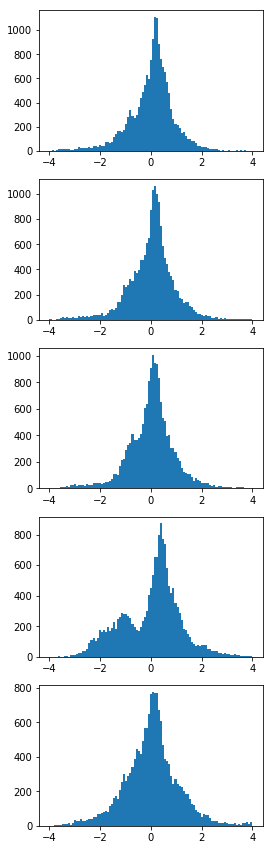

In [521]:
def calidad_histo(model):
    f, axes = plt.subplots(RM.N_out, 1, figsize=(4, 3*RM.N_out))
    red_calidad = model - RM.y_test
    
    for i, ax in enumerate(axes.ravel()):
        x = red_calidad[:,i]
        ax.hist(x, bins=np.linspace(-4, 4, 100))
    
model = RM.pred
calidad_histo(model)

In [522]:
def model(pop):
    RM.set_test(pop)
    RM.predict()
    mod = RM.pred
   
    return mod




In [785]:
def fitness(population):
    mod = model(population)
    mask = ((population >= X_train.min(0)) & (population <= X_train.max(0))).sum(1) != X_train.shape[1]
    fit = -np.sum(((mod[:] - target_phot))**2,1)
    fit[mask] = -np.inf
    return fit


param_dim = X_train.shape
Pop_number = 200000

pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))

generations = 100
M_bad = 10000
N_good = 10
target = -20
p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())
p1.drop(p1[p1['distance'] < target].index, inplace=True)
print(p1.shape)
new_mass = p1['Mass'].max() - p1['Mass'].min()
new_age = p1['Age'].max() - p1['Age'].min()
new_met = p1['Met'].max() - p1['Met'].min()
for gens in np.arange(generations):
    selection = p1.sort_values('distance', ascending = False).head(N_good)
    for index, row in selection.iterrows():
        next_mass = row['Mass'].min() + ( np.random.randn(M_bad) * new_mass)
        next_age = row['Age'].min() + (np.random.randn(M_bad) * new_age)
        next_met = row['Met'].min() + (np.random.randn(M_bad) * new_met)
        new_pop = pd.DataFrame(np.array([next_mass, next_age, next_met]))
        new_pop = new_pop.T
        new_pop.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
        new_pop['distance'] = fitness(new_pop.to_numpy())
        new_pop.drop(new_pop[new_pop['distance'] < target].index, inplace = True)
        p1 = p1.append(new_pop)


(1824, 4)


In [791]:
p1.shape

(242018, 4)

3120.0534649152883 6.813250220489676 0.008116843861571993
   bst_mass
9    1438.0     log_age
9  6.778151


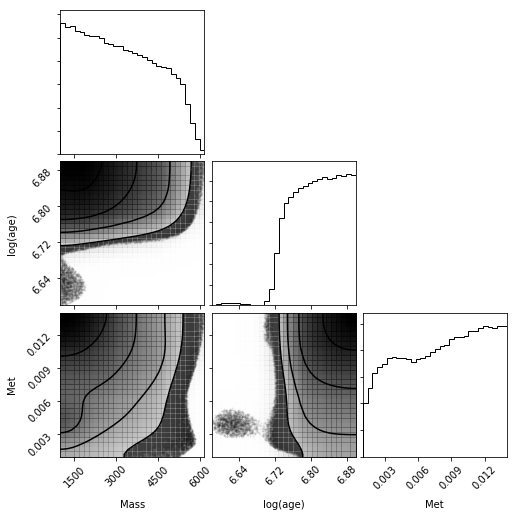

In [790]:
print(p1['Mass'].mean(), p1['Age'].mean(), p1['Met'].mean())
print(obs_1[['bst_mass']], obs_1[['log_age']])
labels = ['Mass', 'log(age)', 'Met']
f = corner.corner(p1[['Mass', 'Age', 'Met']], bins= 30, smooth=3, labels = labels,plot_datapoints=True)


In [767]:
p1.shape

(32263, 4)

In [570]:
len(selection)

10

In [235]:
pop = X_train.min(0) + (X_train.max(0) - X_train.min(0) * np.random.rand(Pop_number, param_dim[-1]))


generations = 10
M_bad = 100
N_good = 50
target = 10
p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())


Test data scaled. 
Training set size = 50918, Test set size = 2000
Predicting from 3 inputs to 7 outputs using 2000 data in 0.01 secs.


In [256]:
pop = X_train.min(0) + (X_train.max(0) - X_train.min(0) * np.random.rand(Pop_number, param_dim[-1]))

In [260]:
pop[:, 0].max()

100999.25976082393

In [332]:
X_train.max(0) - X_train.min(0)

array([9.90000000e+04, 8.99820502e-01, 1.30000000e-02])

In [433]:
def fitness(population):
    mod = model(population)
    fit = -np.sum(((mod[:] - target_phot))**2,1)
    return fit

param_dim = X_train.shape
Pop_number = 2000
pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))

generations = 10
M_bad = 100
N_good = 50
target = -100
p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())
p1.drop(p1[p1['distance'] < target].index, inplace=True)
p1

Test data scaled. 
Training set size = 50918, Test set size = 2000
Predicting from 3 inputs to 7 outputs using 2000 data in 0.01 secs.


,Mass,Age,Met,distance
0,2129.158067,6.829463,0.011063,-18.448049
10,3320.690398,6.048011,0.002810,-33.248940
27,1837.529474,6.013276,0.008320,-22.417783
30,3612.293995,6.221480,0.001061,-41.220442
43,7198.359664,6.310309,0.002338,-68.538803
...,...,...,...,...
1972,7312.452280,6.753625,0.010262,-82.119576
1975,3422.791050,6.456097,0.003917,-42.366051
1984,1228.119215,6.521537,0.012527,-33.106088
1989,2794.731374,6.594762,0.007774,-45.280827


In [411]:
def fitness(population):
    mod = model(population)
    fit = -np.sum(((mod[:] - target_phot))**2,1)
    fit[mask] = -np.inf
    return fit

param_dim = X_train.shape
Pop_number = 2000
pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))

generations = 10
M_bad = 100
N_good = 50

p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())
p1['distance'].max()



Test data scaled. 
Training set size = 50918, Test set size = 2000
Predicting from 3 inputs to 7 outputs using 2000 data in 0.01 secs.


-4602.070612635475

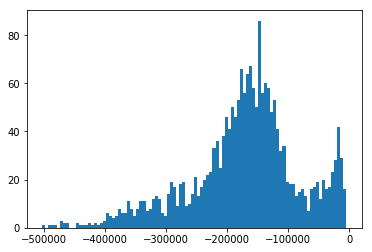

In [413]:
plt.hist(p1['distance'], bins = 100);

In [593]:
param_dim = X_train.shape
Pop_number = 100000


generations = 100
M_bad = 1000
N_good = 50
target = -30
p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())
p1.drop(p1[p1['distance'] < target].index, inplace=True)
new_mass = p1['Mass'].max() - p1['Mass'].min()
new_age = p1['Age'].max() - p1['Age'].min()
new_met = p1['Met'].max() - p1['Met'].min()
for gens in np.arange(generations):
    selection = p1.sort_values('distance', ascending = False).head(N_good)
    for index, row in selection.iterrows():
        next_mass = row['Mass'].min() + ( np.random.randn(M_bad) * new_mass)
        print(row['Mass'])
        next_age = row['Age'] + (np.random.randn(M_bad) * new_age)
        next_met = row['Met'] + np.random.randn(M_bad) * new_met
        break
    break

1885.2787928983216


-16787.4296256987
18010.301612326843
1483.1814458346576


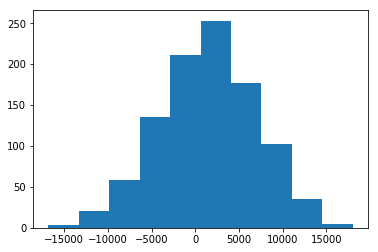

In [594]:
plt.hist(next_mass)
print(next_mass.min())
print(next_mass.max())
print(next_mass.mean())

In [615]:
p1['distance']

23    -18.338501
43    -22.398407
45    -26.547549
50    -20.876412
64    -12.202890
         ...    
777   -29.612172
800    -6.857209
808   -19.617234
841   -28.395713
977   -13.151256
Name: distance, Length: 2408, dtype: float64

In [638]:
a = p1['Mass'].to_numpy()
a.shape

(6899,)

In [686]:
pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))
p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())
p1.drop(p1[p1['distance'] < target].index, inplace=True)
new_mass = p1['Mass'].max() - p1['Mass'].min()
new_age = p1['Age'].max() - p1['Age'].min()
new_met = p1['Met'].max() - p1['Met'].min()
sel = p1.to_numpy()

In [673]:
N_good = 10
mass_sort = np.sort(sel[:,0])
mass_sort = mass_sort[::-1]
age_sort = np.sort(sel[:, 1])
age_sort = age_sort[::-1]
met_sort = np.sort(sel[:, 2])
met_sort = met_sort[::-1]
selection = np.array([mass_sort[:N_good],age_sort[:N_good],met_sort[:N_good]]).T

In [674]:
selection.shape

(10, 3)

In [654]:
var_mass = pop[:, 0].max() - pop[:, 0].min()
var_age = pop[:, 1].max() - pop[:, 1].min()
var_met = pop[:, 2].max() - pop[:, 2].min()

In [657]:
new_mass = selection[:, 0].min() + (var_mass * np.random.randn(M_bad))
new_age = selection[:, 1].min() + (var_age * np.random.randn(M_bad))
new_met = selection[:, 2].min() + (var_met * np.random.randn(M_bad))

In [667]:
selection = 0

In [659]:
new_pop = np.array([new_mass, new_age, new_met])
new_pop.shape

(3, 1000)

In [662]:
mass_sort[::N_good].shape

(10000,)

In [676]:
a = p1['distance'].to_numpy()

In [692]:
pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))
p1 = pd.DataFrame(pop)
p1.rename(columns={0: 'Mass', 1: 'Age', 2: 'Met'}, inplace=True)
p1['distance'] = fitness(p1.to_numpy())
sel = p1.to_numpy()

In [696]:
a = np.sort(sel[:, 3])
a = a[::-1]
a[:10]

array([-1.63656426, -1.69659622, -1.70001416, -1.71660101, -1.72539764,
       -1.75029071, -1.76605859, -1.78508731, -1.80833401, -1.88696608])

In [700]:
b = sel.argsort()

In [703]:
b[:, 3]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [710]:
a = sel[b[:,3]]
a = a[::-1]

In [714]:
columnIndex = 3
sortedArr = sel[sel[:,columnIndex].argsort()]

In [717]:
sortedArr[:, 3]
a = sortedArr[::-1]

In [719]:
a[:,3]

array([  -1.63656426,   -1.69659622,   -1.70001416, ..., -355.23965952,
       -355.32896113, -355.45588135])

In [720]:
a[:10, 0]

array([1327.43909371, 1665.08428503, 2231.34488006, 1137.13233256,
       1414.06123786, 2665.16856902, 1015.5904566 , 3134.92487149,
       1961.05681752, 2499.57874856])

In [721]:
a

array([[ 1.32743909e+03,  6.73058240e+00,  2.89813525e-03,
        -1.63656426e+00],
       [ 1.66508429e+03,  6.73315841e+00,  2.66070615e-03,
        -1.69659622e+00],
       [ 2.23134488e+03,  6.73458025e+00,  3.65503599e-03,
        -1.70001416e+00],
       ...,
       [ 9.66335500e+04,  6.53510233e+00,  1.78337603e-03,
        -3.55239660e+02],
       [ 9.90521668e+04,  6.54123796e+00,  1.76318406e-03,
        -3.55328961e+02],
       [ 9.90926236e+04,  6.52092385e+00,  1.64541500e-03,
        -3.55455881e+02]])

In [727]:
selection = np.array([sortedArr[:10, 0], sortedArr[:10, 1], sortedArr[:10, 2]]).T

In [726]:
len(selection.T)

10

In [734]:
N_worst = 100
for i in range(0, len(selection)):
#Creating new data around the distribution of values of N_best params.
    new_mass = selection[:, 0].min() + (var_mass * np.random.randn(N_worst))
    new_age = selection[:, 1].min() + (var_age * np.random.randn(N_worst))
    new_met = selection[:, 2].min() + (var_met * np.random.randn(N_worst))
                
    new_pop = np.array([new_mass, new_age, new_met]).T

In [740]:
def fitness(population):
    mod = model(population)
    mask = ((population >= X_train.min(0)) & (population <= X_train.max(0))).sum(1) != X_train.shape[1]
    fit = -np.sum(((mod[:] - target_phot))**2,1)
    fit[mask] = -np.inf
    return fit

new_pop_fit = fitness(new_pop)

In [741]:
new_pop_fit

array([         -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -inf,
                -inf,          -inf,          -inf,          -

In [762]:
pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))
pop.shape

(100000, 3)

In [768]:
np.random.seed(0)
pop =  X_train.min(0) + ((X_train.max(0) - X_train.min(0)) * np.random.rand(Pop_number, param_dim[-1]))
pop

array([[5.53325369e+04, 6.64354205e+00, 8.83592389e-03],
       [5.49434351e+04, 6.38121327e+00, 9.39662347e-03],
       [4.43211339e+04, 6.80243563e+00, 1.35276159e-02],
       ...,
       [3.41199806e+04, 6.40398450e+00, 6.18918184e-03],
       [2.19905838e+04, 6.35747118e+00, 5.47475044e-03],
       [6.21593659e+04, 6.30228427e+00, 8.53196480e-03]])